### 2:  Warmup - life without a CLT

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
def monte_carlo(alpha,num_samples, sample_generator, g_evaluator, cumsum=False):
    """Perform Monte Carlo sampling
    
    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples
                 
    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(alpha,num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:        
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)
        
    return estimate, samples, evaluations

In [55]:
def pareto_rv(alpha,xinput):
    p = [alpha/( x**(alpha+1) ) if x>=1 else 0 for x in xinput]
    return p

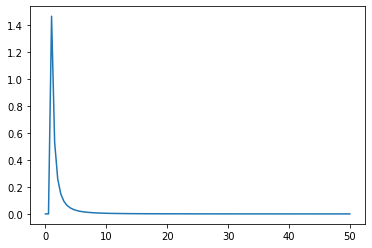

In [56]:
alpha = 3/2
x = np.linspace(0,50,100)
y = pareto_rv(alpha,x)
plt.plot(x,y)

#### CDF of pareto is given by 
\begin{equation}
    CDF = \int_1^x \frac{\alpha}{x^{\alpha+1}} = 1 - \frac{1}{x^{\alpha}}
\end{equation}
Now creating a pareto sampler with Inverse CDF sampler

In [104]:
np.random.seed(10)

def pareto_cdf(alpha,xinput):
    return 1 - 1/xinput**alpha

def pareto_sampler(alpha,num_samples):
    # Function inefficient since it generates sample_space_x_cdf every time it is called
    # Following naming convention from lecture notes
    u = np.random.uniform(size = num_samples)
    sample_space_x = np.linspace(1,500,100000 )   
    sample_space_x_cdf = pareto_cdf(alpha,sample_space_x)
    x_output = []
    for i in range(num_samples):
        index = np.argmax( sample_space_x_cdf > u[i] )
        x_output.append( sample_space_x[index] )
    return x_output

In [102]:
alpha = 3/2
g = lambda x: x # identity function
num_trials = 500
num_samples = 10000
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _, _ = monte_carlo(alpha,num_samples, pareto_sampler, g, cumsum=True)
#     print("one trial: ", estimator_vals[trial, :])

### Plotting

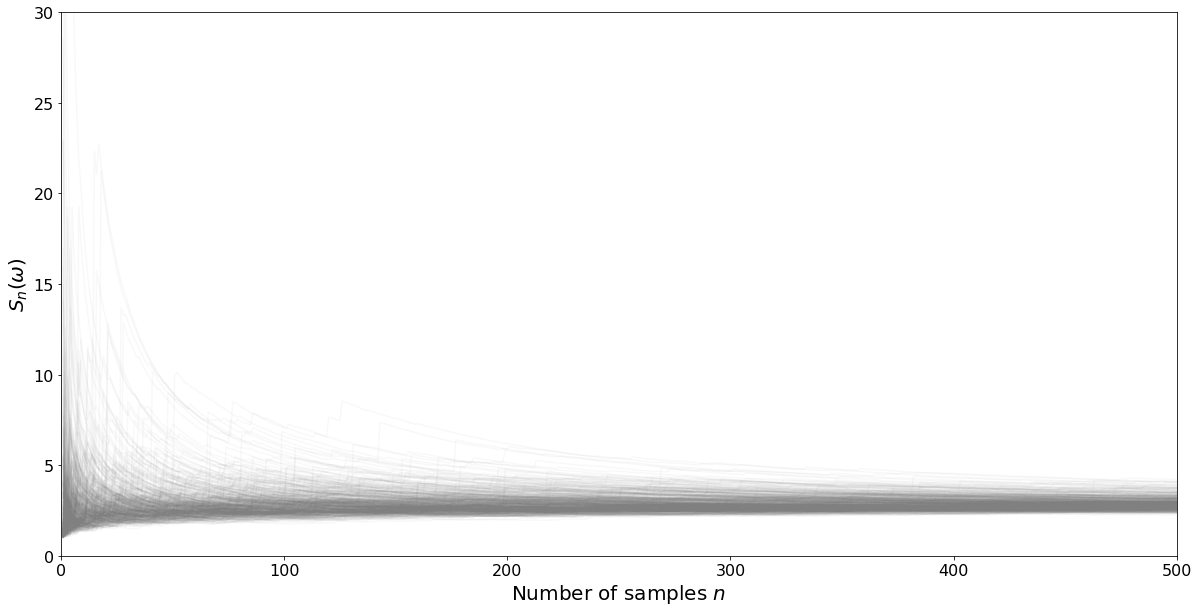

In [105]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+1), estimator_vals.T, color='grey', alpha=0.05)
plt.ylabel(r'$S_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.xlim([0, 500])
plt.ylim([0, 30])
plt.show()

### Getting mean from all trials. actual mean = 3.0

In [113]:
# print(estimator_vals[:,-1])

### Evaluate convergence properties
Copying functions from lecture notebooks on weak_vs_strong_convergence

In [108]:
def estimate_probability_prob(sample_path_errs, epsilon, n):
    """ Estimate the probability of the event related to convergence in probability
    
    sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
    epsilon: float, target error region
    n: positive integer
    """
    
    Npaths, Nsamples_per_path = sample_path_errs.shape
    estimate = np.sum(sample_path_errs[:, n-1] > epsilon) / float(Npaths) #n-1 because indexing by zero
    return estimate

def estimate_probability_as(sample_path_errs, epsilon, n):
    """ Estimate the probability of the event related to convergence almost surely
    
    sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
    epsilon: float, target error region
    n: positive integer
    
    Note
    ----
    This function is a bit inefficient, it would be better if n could be a list of variables so that we can reuse
    the calculations
    """
    
    Npaths, Nsamples_per_path = sample_path_errs.shape
    # Note the difference from in probability ---- we are looking into the future
    # We are looking if any value in the path satisfies the error condition
    paths_satisfy_condition = np.any(sample_path_errs[:, n-1:] > epsilon, axis=1)
    estimate = np.sum(paths_satisfy_condition) / float(Npaths)
    return estimate

In [114]:
epsilon = 0.1
n = np.arange(1, num_samples+1)
prob_as = np.zeros((n.shape[0])) # probability almost surely
prob_p = np.zeros((n.shape[0]))
for ii, nn in enumerate(n):
    # we take absolute values because the true answer is 0
    prob_as[ii] = estimate_probability_as(np.abs(estimator_vals-3.0), epsilon, nn) 
    prob_p[ii] = estimate_probability_prob(np.abs(estimator_vals-3.0), epsilon, nn)

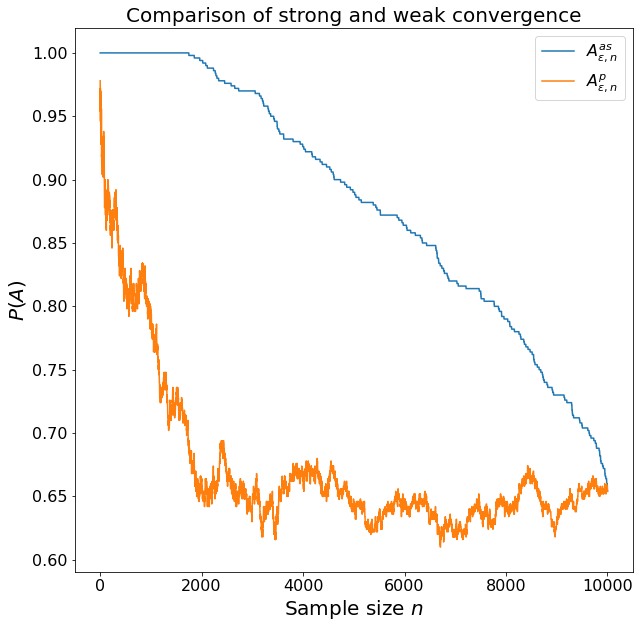

In [115]:
plt.figure(figsize=(10,10))
plt.plot(n, prob_as, label=r'$A_{\epsilon, n}^{as}$')
plt.plot(n, prob_p, label=r'$A_{\epsilon, n}^{p}$')
plt.title('Comparison of strong and weak convergence', fontsize=20)
plt.ylabel(r'$P(A)$', fontsize=20)
plt.xlabel(r'Sample size $n$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()